# The TESS Full-Frame Images Lightcurve of Nova PGIR22akgylf Extracted Using LightKurve Package - Individual Pixel Lightcurves


The eruption of PGIR22akgylf occurred during TESS Sector 55. We extract lightcurves of individual pixels within a 12x12 pixel cutout around the nova position and perform filtering and period search for each single-pixel lightcurve. Our aim is to verify that the 0.1802d periodicity is present only in pixels associated with the nova image and absent in surrounding pixels, as expected for a signal associated with the nova rather than an instrumental effect. We also aim to ditinguish it from another source of periodic signal in this field - a nearby variable star ATO J300.1356+34.8776 also known as ZTF J200032.54+345239.5, KISO J200032.55+345239.4 and Gaia DR3 2059317182140623872 - an eclipsing binary of W UMa type with the orbital period of 0.39754d which produces the a periodogram peak at 0.1991d - half the orbiral period.

The procedure includes:

1. Application of a Savitzky-Golay filter that effectively detrends (flattens) the lightcurve by removing long-term variability
2. Sigma-clipping the lightcurve to remove outliers
3. Constructing a Lomb-Scargle periodogram to identify periodic signals

## Raw Lightcurves - No Background Subtraction

We start by exploring raw pixel lightcurves without background subtraction to keep the individual pixel lightcurves independent of each other.

/home/kirill/.conda/envs/lk/lib/python3.10/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /home/kirill/.lightkurve/cache. Please move all the files in the legacy directory /home/kirill/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


Searching for TESS data for PGIR22akgylf
Found 8 TESS sectors with data
SearchResult containing 8 data products.

 #     mission     year  author exptime        target_name        distance
                                   s                               arcsec 
--- -------------- ---- ------- ------- ------------------------- --------
  0 TESS Sector 14 2019 TESScut    1426 20:00:29.254 +34:53:09.17      0.0
  1 TESS Sector 15 2019 TESScut    1426 20:00:29.254 +34:53:09.17      0.0
  2 TESS Sector 54 2022 TESScut     475 20:00:29.254 +34:53:09.17      0.0
  3 TESS Sector 55 2022 TESScut     475 20:00:29.254 +34:53:09.17      0.0
  4 TESS Sector 74 2024 TESScut     158 20:00:29.254 +34:53:09.17      0.0
  5 TESS Sector 75 2024 TESScut     158 20:00:29.254 +34:53:09.17      0.0
  6 TESS Sector 81 2024 TESScut     158 20:00:29.254 +34:53:09.17      0.0
  7 TESS Sector 82 2024 TESScut     158 20:00:29.254 +34:53:09.17      0.0
Plot TESS image cutout...


<Figure size 800x600 with 0 Axes>

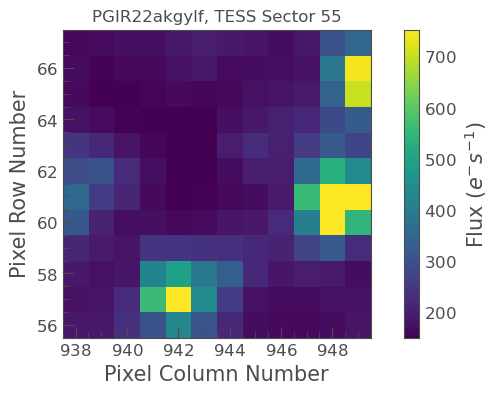

Starting per-pixel periodogram analysis for second half of Sector 55...
Applied TJD filter: 2810.5 to 999999
Number of cadences after filtering: 1924
Cutout dimensions: 12 x 12 pixels
Processing 144 pixels...


  0%|          | 0/12 [00:00<?, ?it/s]

Plot best period map...


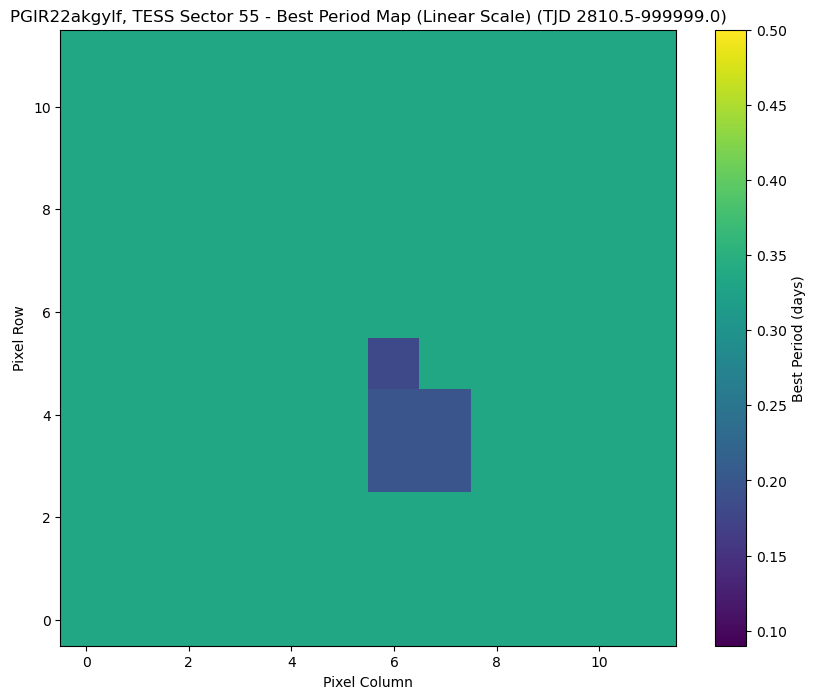

Plot highest periodogram power map...


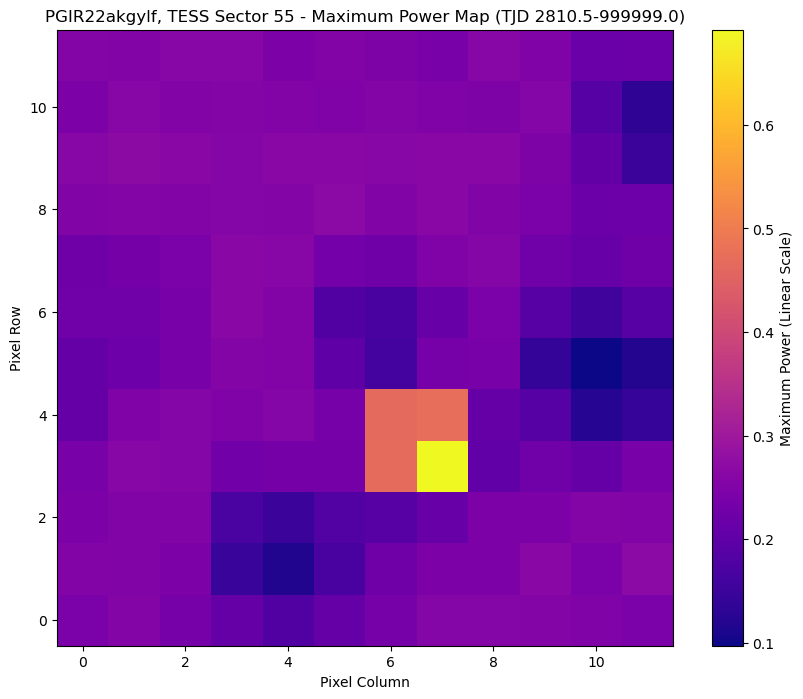

Plot a periodogram for each pixel...


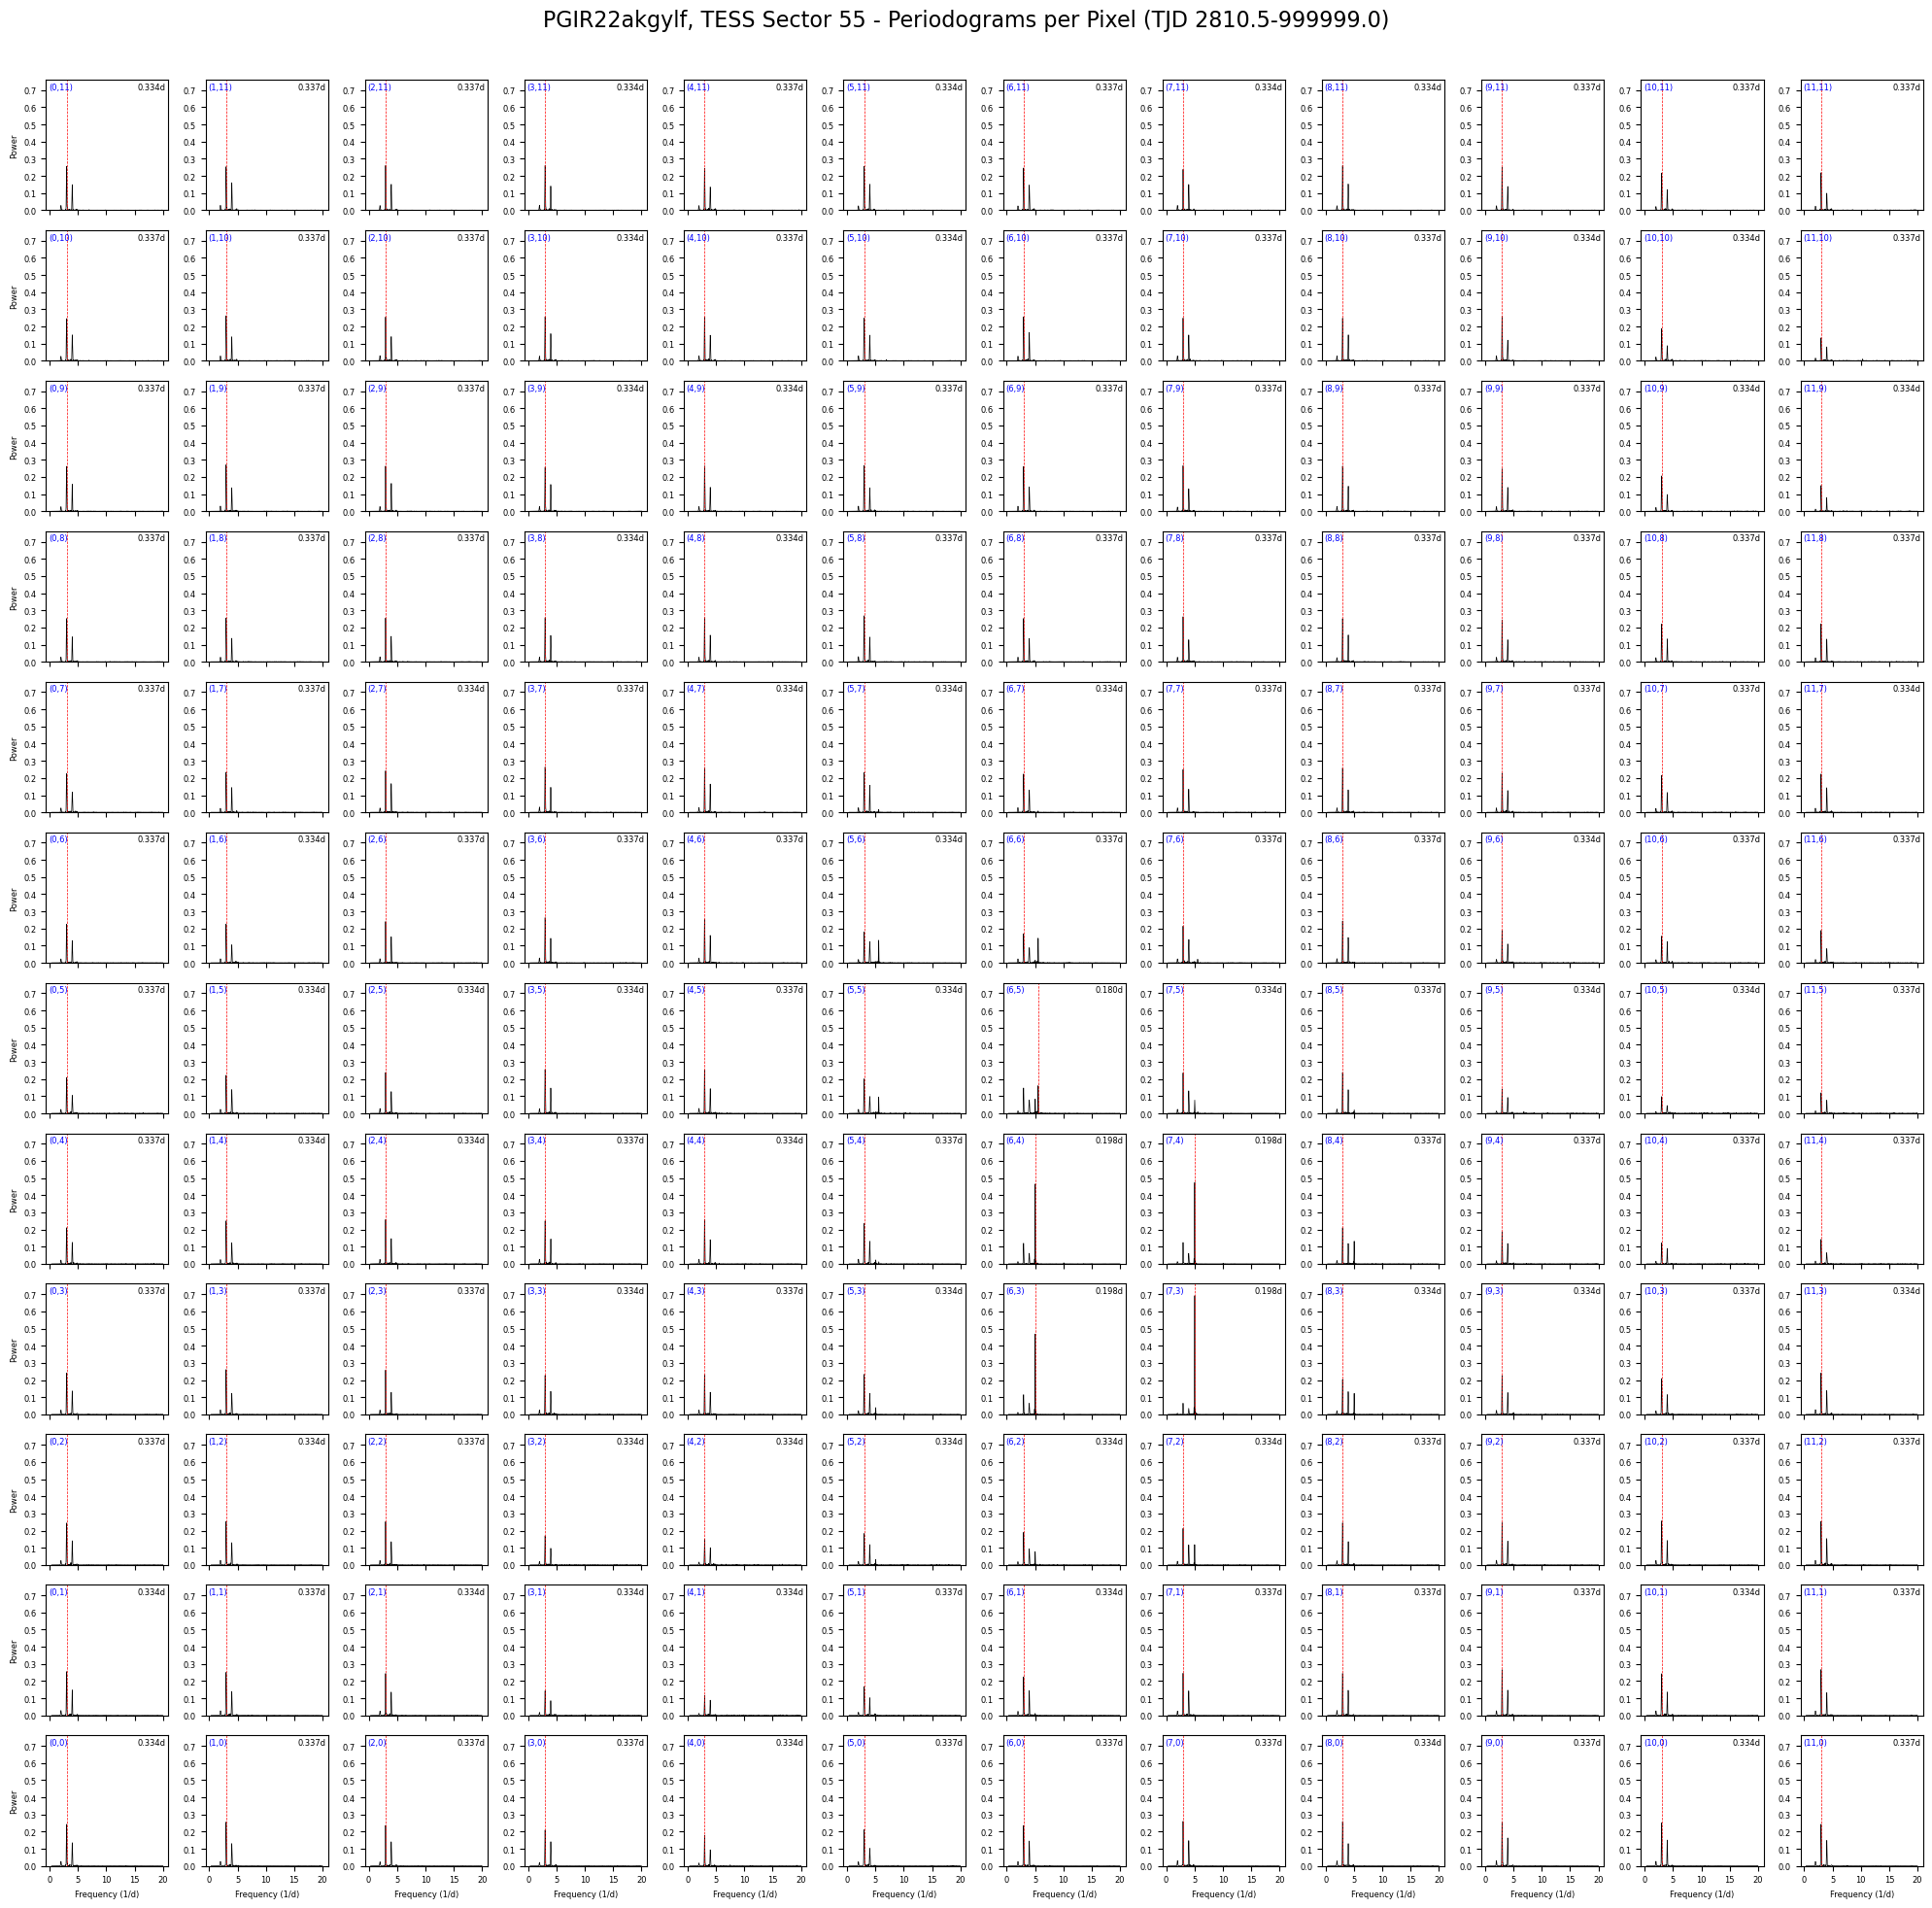

Save periodogram data as '.npy' files for possible future use...
Analysis complete!
Period map shape: (12, 12)
Periodogram array shape: (12, 12, 1000, 2)
Number of pixels with valid periods: 144
Mean period: 0.3308 days
Median period: 0.3366 days
Min period: 0.1802 days
Max period: 0.3366 days


In [1]:
# Per-Pixel Periodogram Analysis for TESS Data
# Import necessary packages
import os
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from matplotlib.colors import LogNorm
from tqdm.notebook import tqdm
from astropy.timeseries import LombScargle
from scipy.signal import savgol_filter  # Added for subtraction-based detrending
%matplotlib inline

def analyze_tess_cutout_per_pixel(tpf_cutout, target_source_name, period_range=(0.05, 3.0), 
                                  notebook_name="PGIR22akgylf_per_pixel_analysis",
                                  detrend_method="subtraction", tjd_range=None):
    """
    Process TESS lightcurve data from a TPF cutout and perform period search on each pixel individually.
    
    Parameters:
    tpf_cutout: TargetPixelFile
        The TPF cutout object containing the data.
    target_source_name: str
        The name of the target source.
    period_range: tuple
        The range of periods (in days) to search for.
    notebook_name: str
        The name of the Jupyter notebook (used to name the output directory).
    detrend_method: str
        Method for detrending - "subtraction" (default) or "division"
    tjd_range: tuple of float or None
        Optional tuple of (tjd_min, tjd_max) to filter the lightcurve data.
        If provided, only data points within this TJD range will be included in the analysis.
    
    Returns:
    period_map: 2D numpy array
        Array containing the best period for each pixel.
    power_map: 2D numpy array
        Array containing the maximum power for each pixel.
    """
    # Create output directory
    output_dir = notebook_name.lower().replace(" ", "_")
    os.makedirs(output_dir, exist_ok=True)
    
    # Apply TJD range filter if specified
    if tjd_range is not None:
        tjd_min, tjd_max = tjd_range
        time_mask = (tpf_cutout.time.value >= tjd_min) & (tpf_cutout.time.value <= tjd_max)
        tpf_cutout = tpf_cutout[time_mask]
        print(f"Applied TJD filter: {tjd_min} to {tjd_max}")
        print(f"Number of cadences after filtering: {len(tpf_cutout)}")
        
        # Check if we have any data points left
        if len(tpf_cutout) == 0:
            print(f"Warning: No data points found in the specified TJD range [{tjd_min}, {tjd_max}]")
            return
        
        # Update filename suffix for TJD range
        tjd_min_int = int(round(tjd_min))
        tjd_max_int = int(round(tjd_max))
        tjd_suffix = f"_TJD{tjd_min_int}-{tjd_max_int}"
    else:
        tjd_suffix = "_fullTJDrange"
    
    # Get the dimensions of the cutout
    rows, cols = tpf_cutout[0].shape[1:]
    print(f"Cutout dimensions: {rows} x {cols} pixels")
    
    # Create arrays to store results
    period_map = np.zeros((rows, cols))
    power_map = np.zeros((rows, cols))
    
    # Define the frequency grid for all periodograms
    min_period, max_period = period_range
    min_frequency = 1 / max_period
    max_frequency = 1 / min_period
    
    # We'll define a common frequency grid for all pixels
    frequency_grid = np.linspace(min_frequency, max_frequency, 1000)
    
    # Create a 4D array to store periodogram data for each pixel
    # (rows, cols, frequencies, [frequency, power])
    periodogram_array = np.zeros((rows, cols, len(frequency_grid), 2))
    
    # Store the frequency grid in all pixels
    for i in range(rows):
        for j in range(cols):
            periodogram_array[i, j, :, 0] = frequency_grid
    
    # Process each pixel
    print(f"Processing {rows*cols} pixels...")
    for i in tqdm(range(rows)):
        for j in range(cols):
            # Create a mask for this specific pixel
            pixel_mask = np.zeros((rows, cols), dtype=bool)
            pixel_mask[i, j] = True
            
            try:
                # Extract the lightcurve for this pixel
                pixel_lc = tpf_cutout.to_lightcurve(aperture_mask=pixel_mask)
                
                # Skip pixels with no data or all zeros/NaNs
                if len(pixel_lc.flux) == 0 or np.all(pixel_lc.flux == 0) or np.all(np.isnan(pixel_lc.flux)):
                    period_map[i, j] = np.nan
                    power_map[i, j] = np.nan
                    continue
                
                # Remove NaN values
                pixel_lc = pixel_lc.remove_nans()
                
                # Skip if too few points remain
                if len(pixel_lc.flux) < 10:
                    period_map[i, j] = np.nan
                    power_map[i, j] = np.nan
                    continue
                
                # Process the lightcurve: remove outliers, detrend, etc.
                pixel_lc = pixel_lc.remove_outliers(sigma=3)
                
                # Skip if too many points were removed
                if len(pixel_lc.flux) < 10:
                    period_map[i, j] = np.nan
                    power_map[i, j] = np.nan
                    continue
                
                # MODIFIED: Perform detrending based on the specified method
                if detrend_method == "division":
                    # Original method: division-based detrending using flatten()
                    pixel_lc = pixel_lc.flatten(window_length=101, polyorder=5)
                elif detrend_method == "subtraction":
                    # New method: subtraction-based detrending using Savitzky-Golay filter
                    # Get the time and flux arrays
                    time = pixel_lc.time.value
                    flux = pixel_lc.flux.value
                    
                    # Compute the trend using Savitzky-Golay filter
                    trend = savgol_filter(flux, window_length=101, polyorder=5)
                    
                    # Create a new lightcurve with the detrended flux (subtraction)
                    pixel_lc = lk.LightCurve(time=pixel_lc.time, flux=flux - trend)
                else:
                    raise ValueError("detrend_method must be either 'division' or 'subtraction'")
                
                # Remove outliers again
                pixel_lc = pixel_lc.remove_outliers(sigma=3)
                
                # Skip if too many points were removed after detrending
                if len(pixel_lc.flux) < 10:
                    period_map[i, j] = np.nan
                    power_map[i, j] = np.nan
                    continue
                
                # Calculate the periodogram using the pre-defined frequency grid
                ls = LombScargle(pixel_lc.time.value, pixel_lc.flux.value)
                power = ls.power(frequency_grid)
                
                # Store the power values in the periodogram array
                periodogram_array[i, j, :, 1] = power
                
                # Find the best period
                best_idx = np.argmax(power)
                best_frequency = frequency_grid[best_idx]
                best_period = 1.0 / best_frequency
                max_power = power[best_idx]
                
                # Store the results
                period_map[i, j] = best_period
                power_map[i, j] = max_power
                
            except Exception as e:
                print(f"Error processing pixel ({i}, {j}): {str(e)}")
                period_map[i, j] = np.nan
                power_map[i, j] = np.nan
    
    # Create a heatmap of the best periods with custom period range
    plt.figure(figsize=(10, 8))
    
    # Use a masked array for better visualization
    masked_period_map = np.ma.masked_invalid(period_map)
    
    # You can change vmin and vmax to customize the period range displayed
    # For example, to focus on periods between 0.1 and 1.0 days:
    #display_min_period = min_period  # Default is min_period from period_range
    #display_max_period = max_period  # Default is max_period from period_range
    display_min_period = 0.5
    display_max_period = 0.1
    
    # You can also choose a different colormap here
    # Some good linear colormaps: 'viridis', 'plasma', 'magma', 'cividis', 'rainbow'
    print("Plot best period map...")
    plt.imshow(masked_period_map, origin='lower', cmap='viridis', 
               vmin=display_min_period, vmax=display_max_period)
    cbar = plt.colorbar(label='Best Period (days)')
    
    # Update title to include TJD range information
    title_str = f"{target_source_name}, TESS Sector {tpf_cutout.sector} - Best Period Map (Linear Scale)"
    if tjd_range is not None:
        title_str += f" (TJD {tjd_range[0]:.1f}-{tjd_range[1]:.1f})"
    plt.title(title_str)
    plt.xlabel('Pixel Column')
    plt.ylabel('Pixel Row')
    
    # Save the period map
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_period_map{tjd_suffix}.png"), 
                format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_period_map{tjd_suffix}.eps"), 
                format="eps")
    plt.show()
    
    # Create a heatmap of the maximum power - with option for linear scale
    print("Plot highest periodogram power map...")
    plt.figure(figsize=(10, 8))
    
    # Use a masked array for better visualization
    masked_power_map = np.ma.masked_invalid(power_map)
    
    # Option 1: Use log normalization (default)
    use_log_scale = False  # Set to False for linear scale
    
    if use_log_scale:
        # Use log normalization for better visibility of wide dynamic range
        norm = LogNorm(vmin=max(np.nanmin(power_map), 1e-10), 
                      vmax=max(np.nanmax(power_map), 1e-9))
        plt.imshow(masked_power_map, origin='lower', cmap='plasma', norm=norm)
        scale_label = "Maximum Power (Log Scale)"
    else:
        # Use linear scale
        plt.imshow(masked_power_map, origin='lower', cmap='plasma')
        scale_label = "Maximum Power (Linear Scale)"
    
    cbar = plt.colorbar(label=scale_label)
    
    # Update title to include TJD range information
    title_str = f"{target_source_name}, TESS Sector {tpf_cutout.sector} - Maximum Power Map"
    if tjd_range is not None:
        title_str += f" (TJD {tjd_range[0]:.1f}-{tjd_range[1]:.1f})"
    plt.title(title_str)
    plt.xlabel('Pixel Column')
    plt.ylabel('Pixel Row')
    
    # Save the power map
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_power_map{tjd_suffix}.png"), 
                format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_power_map{tjd_suffix}.eps"), 
                format="eps")
    plt.show()
    
    # Create a grid of periodograms
    print("Plot a periodogram for each pixel...")
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20), sharex=True)
    
    # Set a common y-axis limit
    max_power_overall = np.nanmax(periodogram_array[:, :, :, 1])
    
    # MODIFIED: Loop through grid in reverse row order to match image orientation
    # This will make the bottom row of periodograms correspond to the bottom row of pixels
    for i in range(rows-1, -1, -1):  # Iterate rows in reverse order
        row_idx = rows - 1 - i  # This maps the reversed row index to the grid position
        for j in range(cols):
            ax = axes[row_idx, j]  # Use the transformed row index
            
            # Check if we have valid data for this pixel
            if not np.isnan(period_map[i, j]):
                # Plot the periodogram
                frequencies = periodogram_array[i, j, :, 0]
                powers = periodogram_array[i, j, :, 1]
                
                ax.plot(frequencies, powers, 'k-', linewidth=0.5)
                
                # Highlight the best period
                best_frequency = 1 / period_map[i, j]
                ax.axvline(x=best_frequency, color='r', linestyle='--', linewidth=0.5)
                
                # Set y-axis limit
                ax.set_ylim(0, max_power_overall * 1.1)
                
                # Display the best period in the upper right corner
                ax.text(0.98, 0.98, f"{period_map[i, j]:.3f}d", 
                        horizontalalignment='right', verticalalignment='top',
                        transform=ax.transAxes, fontsize=6)
                
                # Add pixel coordinates for reference
                ax.text(0.02, 0.98, f"({j},{i})", 
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes, fontsize=6, color='blue')
            
            # Remove ticks for cleaner look
            ax.tick_params(axis='both', which='both', labelsize=6)
            
            # Only add axis labels for the bottom and left edges
            if row_idx == rows-1:
                ax.set_xlabel('Frequency (1/d)', fontsize=6)
            if j == 0:
                ax.set_ylabel('Power', fontsize=6)
    
    # Update title to include TJD range information
    title_str = f"{target_source_name}, TESS Sector {tpf_cutout.sector} - Periodograms per Pixel"
    if tjd_range is not None:
        title_str += f" (TJD {tjd_range[0]:.1f}-{tjd_range[1]:.1f})"
    plt.suptitle(title_str, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust for the suptitle
    
    # Save the periodogram grid
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_periodogram_grid{tjd_suffix}.png"), 
                format="png", dpi=600)
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_periodogram_grid{tjd_suffix}.eps"), 
                format="eps")
    plt.show()
    
    # Also save the data as numpy arrays for future use
    print("Save periodogram data as '.npy' files for possible future use...")
    np.save(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_period_map{tjd_suffix}.npy"), 
            period_map)
    np.save(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_power_map{tjd_suffix}.npy"), 
            power_map)
    np.save(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_periodogram_array{tjd_suffix}.npy"), 
            periodogram_array)
    
    # Return the maps for further analysis
    return period_map, power_map, periodogram_array

# ---------- RUN THE ANALYSIS ----------

# Set target source name and position, search for TESS data
target_source_name = "PGIR22akgylf"
# Position from Koji's nova list
print("Searching for TESS data for", target_source_name)
search_lc = lk.search_tesscut("20:00:29.254 +34:53:09.17")
print(f"Found {len(search_lc)} TESS sectors with data")
print(search_lc)

# Download and plot the TESS FFI cutout centered on the source
# We're using sector 3 (index 3) which corresponds to Sector 55
print(f"Downloading cutout for Sector {search_lc[3].mission[0]}")
tpf_cutout = search_lc[3].download(cutout_size=12, quality_bitmask='hard')

# Plot the cutout
print("Plot TESS image cutout...")
plt.figure(figsize=(8, 6))
tpf_cutout.plot()
plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}")
plt.show()

# Run the per-pixel analysis for the second half of Sector 55 (when nova is bright)
print("Starting per-pixel periodogram analysis for second half of Sector 55...")
period_map, power_map, periodogram_array = analyze_tess_cutout_per_pixel(
    tpf_cutout, 
    target_source_name,
    period_range=(0.05, 3.0),
    notebook_name="PGIR22akgylf_per_pixel_analysis",
    detrend_method="subtraction",  # Using subtraction-based detrending
    tjd_range=(2810.5, 999999)    # Second half of Sector 55
)

print("Analysis complete!")
print(f"Period map shape: {period_map.shape}")
print(f"Periodogram array shape: {periodogram_array.shape}")

# Print some statistics about the detected periods
valid_periods = period_map[~np.isnan(period_map)]
if len(valid_periods) > 0:
    print(f"Number of pixels with valid periods: {len(valid_periods)}")
    print(f"Mean period: {np.mean(valid_periods):.4f} days")
    print(f"Median period: {np.median(valid_periods):.4f} days")
    print(f"Min period: {np.min(valid_periods):.4f} days")
    print(f"Max period: {np.max(valid_periods):.4f} days")
else:
    print("No valid periods detected in any pixel.")

The periodogram map reveals two distinct periodicities in individual pixel lightcurves: a 0.198d period found in the pixels associated with the eclipsing binary, and a 0.334d period present in all other pixels. The 0.334d period is clearly an instrumental feature, as it affects many pixels across the image. Since we applied a Savitzky-Golay filter to the lightcurves before constructing the Lomb-Scargle periodogram, it's possible that the true instrumental period is a multiple of 0.334d (0.334d being the lowest harmonic of the true instrumental period that isn't suppressed by the filter).


## Background-Subtracted Lightcurves of Individual Pixels

Now let's repeat the individual pixel lightcurve analysis, but perform background subtraction to eliminate the 0.334d instrumental period associated with the background. We construct a background extraction region from the faintest pixels of the cutout. The total counts extracted from that region are divided by the number of pixels in the background extraction aperture to obtain a per-pixel lightcurve that can be subtracted from single-pixel lightcurves.

We also apply filtering followed by Lomb-Scargle period analysis to the background lightcurve (the same procedure we apply for individual pixels) to confirm the presence of the 0.334d period. 

We subtract the original (unfiltered) background lightcurve from the individual pixel lightcurves and repeat the analysis performed for the raw pixel lightcurves above (filtering background-subtracted lightcurve, Lomb-Scargle), constructing a best period map, a highest periodogram peak map, and individual pixel periodograms.


Searching for TESS data for PGIR22akgylf
Found 8 TESS sectors with data
SearchResult containing 8 data products.

 #     mission     year  author exptime        target_name        distance
                                   s                               arcsec 
--- -------------- ---- ------- ------- ------------------------- --------
  0 TESS Sector 14 2019 TESScut    1426 20:00:29.254 +34:53:09.17      0.0
  1 TESS Sector 15 2019 TESScut    1426 20:00:29.254 +34:53:09.17      0.0
  2 TESS Sector 54 2022 TESScut     475 20:00:29.254 +34:53:09.17      0.0
  3 TESS Sector 55 2022 TESScut     475 20:00:29.254 +34:53:09.17      0.0
  4 TESS Sector 74 2024 TESScut     158 20:00:29.254 +34:53:09.17      0.0
  5 TESS Sector 75 2024 TESScut     158 20:00:29.254 +34:53:09.17      0.0
  6 TESS Sector 81 2024 TESScut     158 20:00:29.254 +34:53:09.17      0.0
  7 TESS Sector 82 2024 TESScut     158 20:00:29.254 +34:53:09.17      0.0
Plot the TESS image cutout...
Starting per-pixel periodogram 

  0%|          | 0/12 [00:00<?, ?it/s]

Plot best period map...


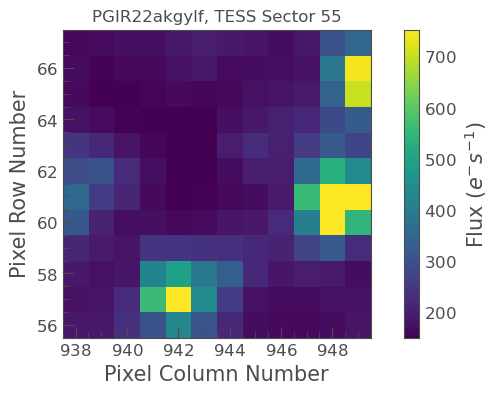

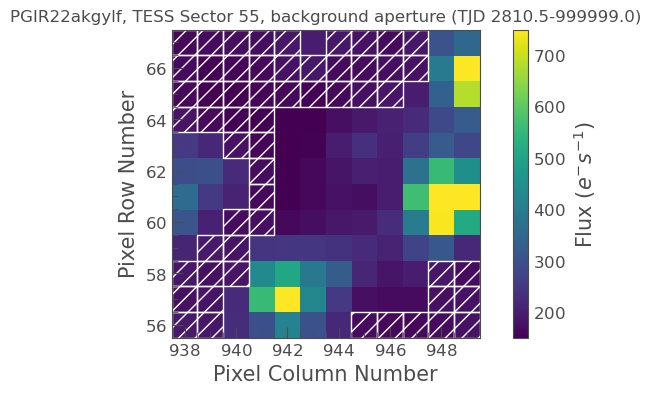

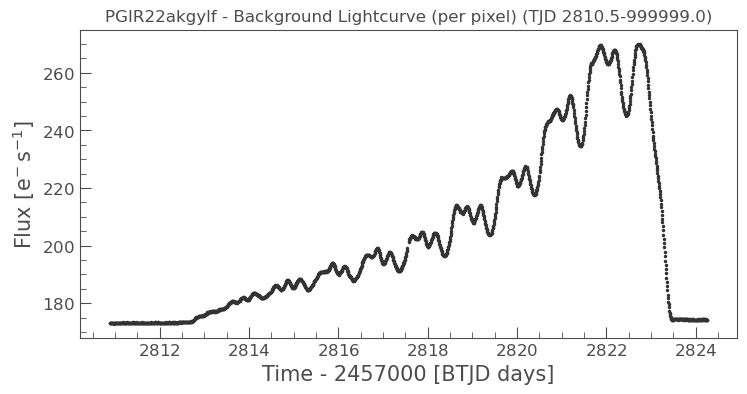

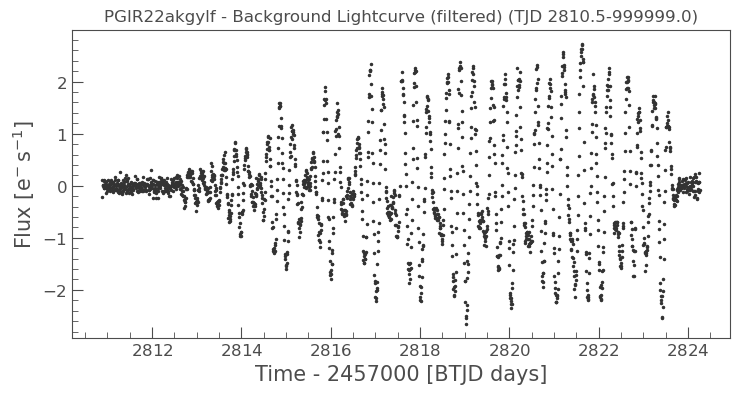

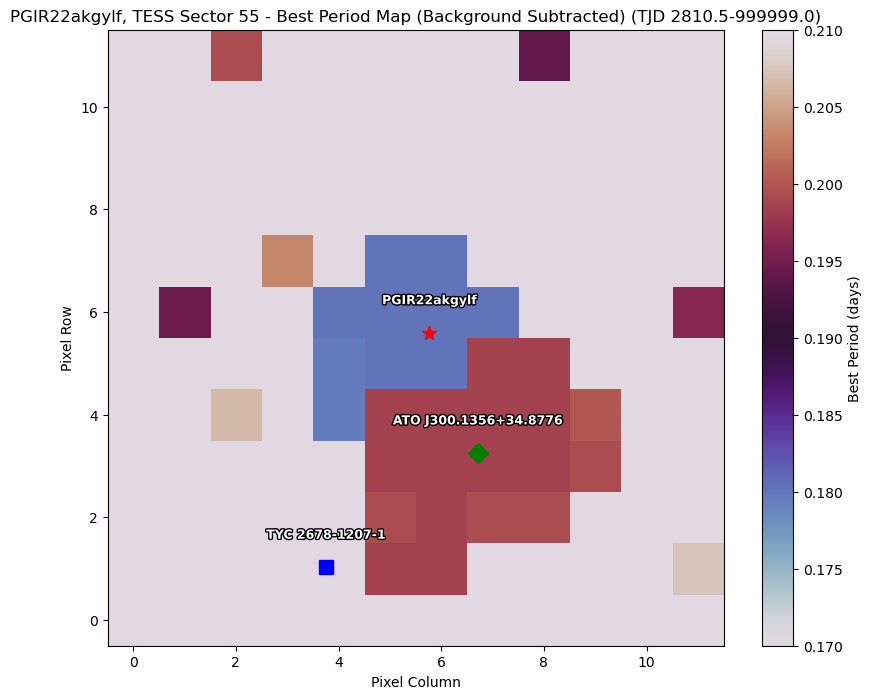

Plot the highest periodogram power map...


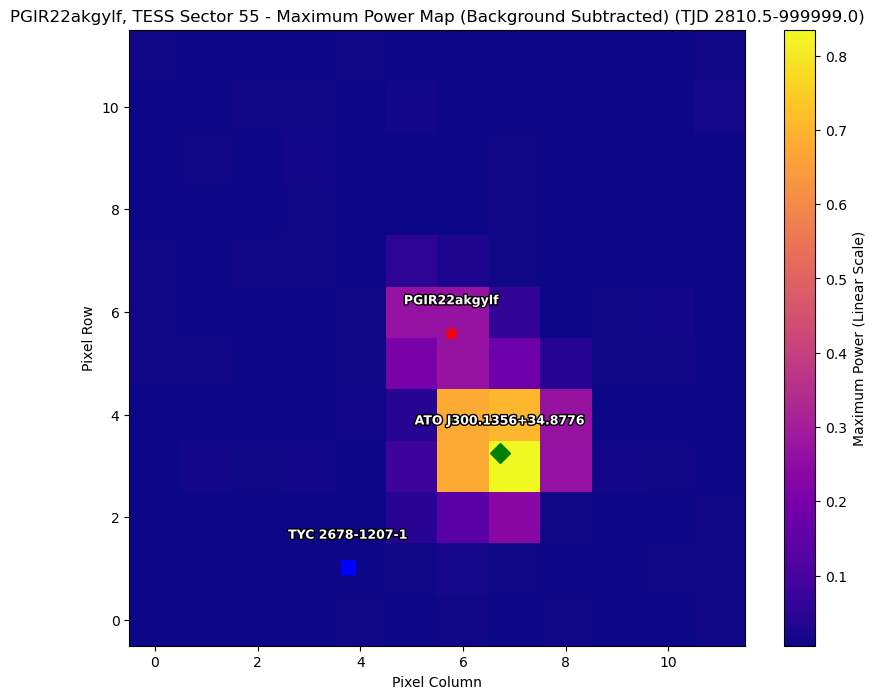

Plot periodograms for the individual pixels...


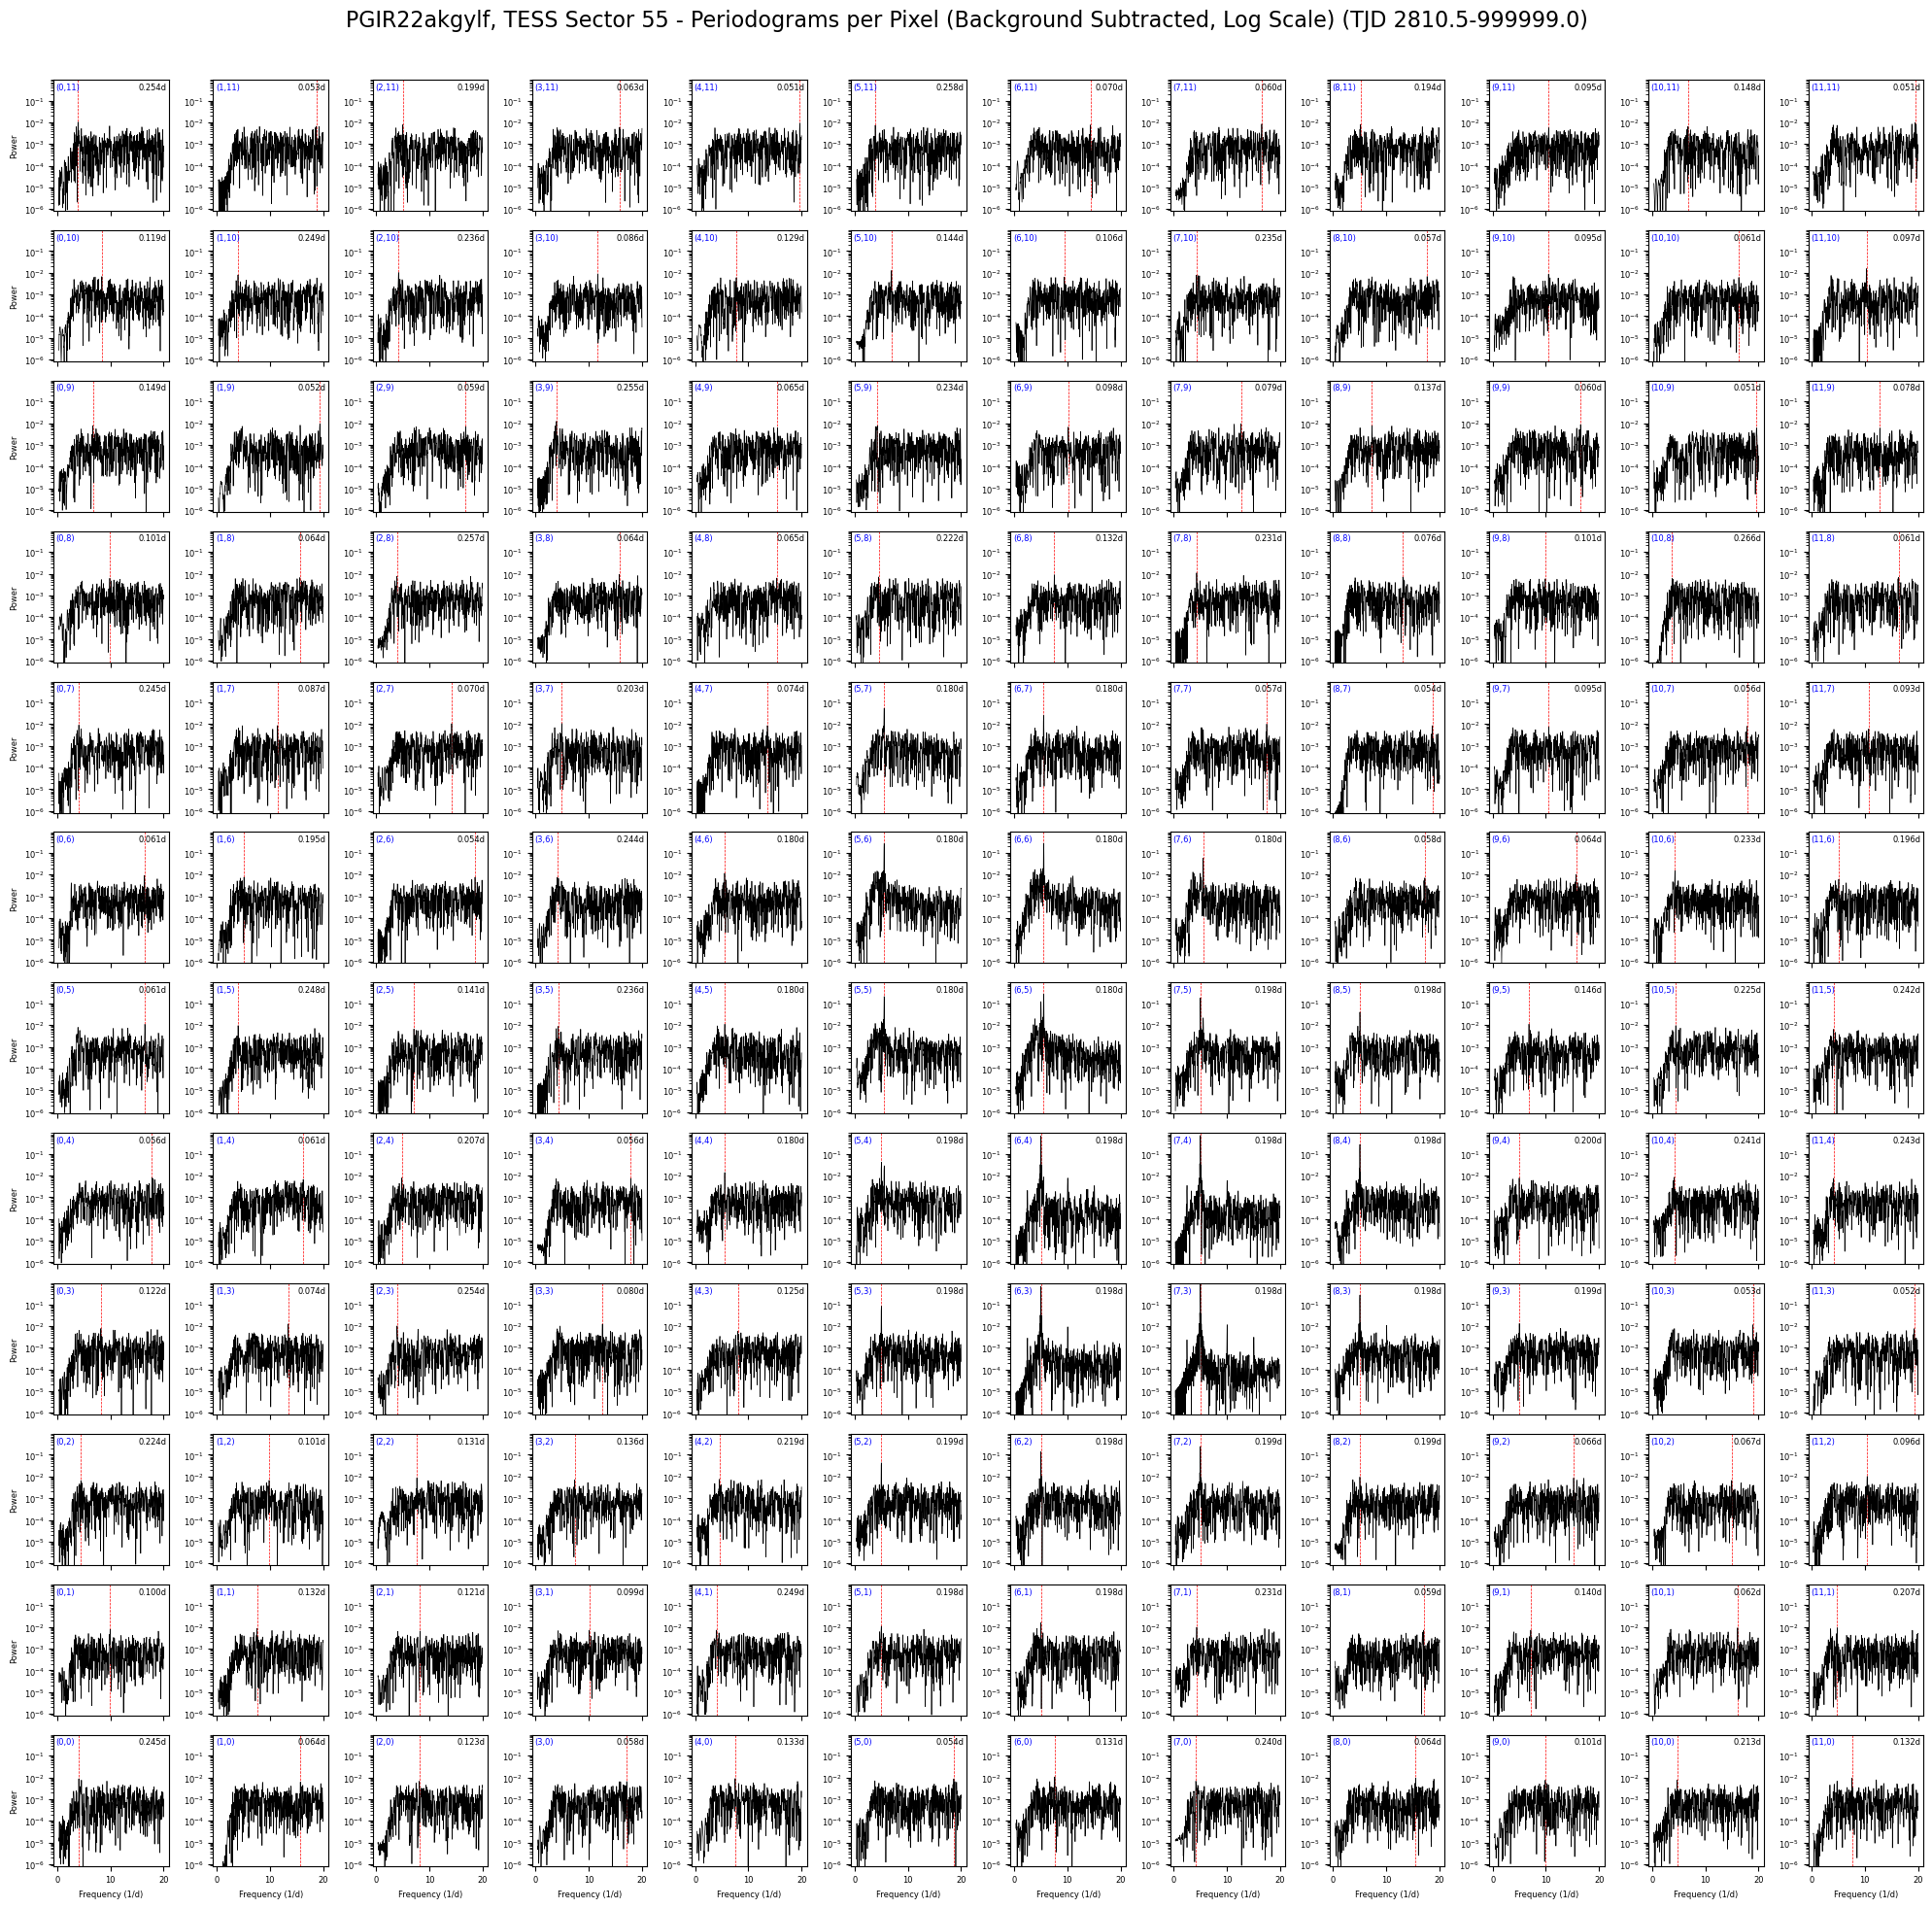

Save periodogram data as '.npy' files for possible future use...
Analysis complete!
Period map shape: (12, 12)
Periodogram array shape: (12, 12, 1000, 2)
Background best period: 0.3366 days
Number of pixels with valid periods: 144
Mean period: 0.1424 days
Median period: 0.1327 days
Min period: 0.0508 days
Max period: 0.2660 days


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from matplotlib.colors import LogNorm
from tqdm.notebook import tqdm
from astropy.timeseries import LombScargle
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.signal import savgol_filter  # Added for subtraction-based detrending
%matplotlib inline

def add_markers_to_cutout_plot(ax, tpf_cutout, source_coords):
    """Add markers for the three sources to cutout coordinate plots (period/power maps)."""
    import matplotlib.patheffects as path_effects
    
    markers = ['*', 's', 'D']  # star, square, diamond
    colors = ['red', 'blue', 'green']
    
    for i, (name, skycoord) in enumerate(source_coords):
        # Get the local pixel coordinates within the cutout
        local_x, local_y = tpf_cutout.wcs.world_to_pixel(skycoord)
        
        # Extract scalar values from arrays (world_to_pixel returns arrays)
        local_x = float(local_x)
        local_y = float(local_y)
        
        # For cutout coordinate plots, use the LOCAL coordinates directly
        # No need to add tpf_cutout.column/row since we're in cutout coordinates
        
        # Plot the marker using LOCAL cutout coordinates
        ax.plot(local_x, local_y, marker=markers[i], markersize=10, color=colors[i])
        
        # Add text label 0.5 pixel above the marker with bold white text
        # No frame around the text, white color with black outline for visibility
        text = ax.text(local_x, local_y + 0.5, name, fontsize=9, color='white', fontweight='bold',
               ha='center', va='bottom')
        text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='black')])


def analyze_tess_cutout_per_pixel_with_bkg_sub(tpf_cutout, target_source_name, period_range=(0.05, 3.0), 
                                  notebook_name="PGIR22akgylf_per_pixel_analysis_bkg_sub",
                                  bkg_threshold=0.5,
                                  detrend_method="subtraction", tjd_range=None):
    """
    Process TESS lightcurve data from a TPF cutout, perform background subtraction, and
    run period search on each background-subtracted pixel individually.
    
    Parameters:
    tpf_cutout: TargetPixelFile
        The TPF cutout object containing the data.
    target_source_name: str
        The name of the target source.
    period_range: tuple
        The range of periods (in days) to search for.
    notebook_name: str
        The name of the Jupyter notebook (used to name the output directory).
    bkg_threshold: float
        Threshold for background mask creation (lower = more conservative background).
    detrend_method: str
        Method for detrending - "subtraction" (default) or "division"
    tjd_range: tuple of float or None
        Optional tuple of (tjd_min, tjd_max) to filter the lightcurve data.
        If provided, only data points within this TJD range will be included in the analysis.
    
    Returns:
    period_map: 2D numpy array
        Array containing the best period for each pixel.
    power_map: 2D numpy array
        Array containing the maximum power for each pixel.
    background_period: float
        The best period detected in the background lightcurve.
    background_power: float
        The maximum power in the background periodogram.
    """
    # Define the source coordinates for markers
    source_coords = [
        ('PGIR22akgylf', SkyCoord('20:00:29.254 +34:53:09.17', unit=(u.hourangle, u.deg))),
        ('TYC 2678-1207-1', SkyCoord('20:00:30.1586813 +34:51:34.456302', unit=(u.hourangle, u.deg))),
        ('ATO J300.1356+34.8776', SkyCoord('20:00:32.5503041 +34:52:39.529398', unit=(u.hourangle, u.deg)))
    ]
    
    # Create output directory
    output_dir = notebook_name.lower().replace(" ", "_")
    os.makedirs(output_dir, exist_ok=True)
    
    # Apply TJD range filter if specified
    if tjd_range is not None:
        tjd_min, tjd_max = tjd_range
        time_mask = (tpf_cutout.time.value >= tjd_min) & (tpf_cutout.time.value <= tjd_max)
        tpf_cutout = tpf_cutout[time_mask]
        print(f"Applied TJD filter: {tjd_min} to {tjd_max}")
        print(f"Number of cadences after filtering: {len(tpf_cutout)}")
        
        # Check if we have any data points left
        if len(tpf_cutout) == 0:
            print(f"Warning: No data points found in the specified TJD range [{tjd_min}, {tjd_max}]")
            return
        
        # Update filename suffix for TJD range
        tjd_min_int = int(round(tjd_min))
        tjd_max_int = int(round(tjd_max))
        tjd_suffix = f"_TJD{tjd_min_int}-{tjd_max_int}"
    else:
        tjd_suffix = "_fullTJDrange"
    
    # Get the dimensions of the cutout
    rows, cols = tpf_cutout[0].shape[1:]
    print(f"Cutout dimensions: {rows} x {cols} pixels")
    
    # Create arrays to store results
    period_map = np.zeros((rows, cols))
    power_map = np.zeros((rows, cols))
    
    # Define the frequency grid for all periodograms
    min_period, max_period = period_range
    min_frequency = 1 / max_period
    max_frequency = 1 / min_period
    
    # We'll define a common frequency grid for all pixels
    frequency_grid = np.linspace(min_frequency, max_frequency, 1000)
    
    # Create a 4D array to store periodogram data for each pixel
    # (rows, cols, frequencies, [frequency, power])
    periodogram_array = np.zeros((rows, cols, len(frequency_grid), 2))
    
    # Store the frequency grid in all pixels
    for i in range(rows):
        for j in range(cols):
            periodogram_array[i, j, :, 0] = frequency_grid
    
    # ---------- BACKGROUND ANALYSIS ----------
    print("Creating and analyzing background mask...")
    
    # Create and display the background aperture using the specified threshold of 0.001
    
    # Manually mask-out the target source
    custom_background_exclusion_mask = np.zeros((tpf_cutout.shape[1:]), dtype='bool')
    custom_background_exclusion_mask[4:9, 4:9] = True  # extended target region
    custom_background_exclusion_mask[1:6, 5:10] = True # ATO J300.1356+34.8776 eclipsing binary region
    
    # This creates a conservative background mask that doesn't include light from stars
    background_mask = ~tpf_cutout.create_threshold_mask(threshold=0.001, reference_pixel=None) * ~custom_background_exclusion_mask
    
    # Format filenames
    target_source_name_lowercase_for_filename = target_source_name.lower().replace(" ", "_")
    sector_name_lowercase_for_filename = f"sector{tpf_cutout.sector}"
    
    # Plot the background mask
    print("Plot the TESS image cutout marking the background extraction region...")
    fig = plt.figure(figsize=(8, 6))
    tpf_cutout.plot(aperture_mask=background_mask, mask_color='w')
    
    # Update title to include TJD range information
    title_str = f"{target_source_name}, TESS Sector {tpf_cutout.sector}, background aperture"
    if tjd_range is not None:
        title_str += f" (TJD {tjd_range[0]:.1f}-{tjd_range[1]:.1f})"
    plt.title(title_str)
    
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_aperture_plot{tjd_suffix}.png"), format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_aperture_plot{tjd_suffix}.eps"), format="eps")
    plt.close(fig)
    
    # Extract the background lightcurve
    n_background_pixels = background_mask.sum()
    
    if n_background_pixels > 0:
        background_lc = tpf_cutout.to_lightcurve(aperture_mask=background_mask)
        background_lc_per_pixel = background_lc / n_background_pixels
        
        # Plot the raw background lightcurve
        print("Plot the background lightcurve...")
        fig = plt.figure(figsize=(12, 5))
        background_lc_per_pixel.plot(lw=1, marker='.', markersize=3, linestyle='None')
        
        # Update title to include TJD range information
        title_str = f"{target_source_name} - Background Lightcurve (per pixel)"
        if tjd_range is not None:
            title_str += f" (TJD {tjd_range[0]:.1f}-{tjd_range[1]:.1f})"
        plt.title(title_str)
        
        plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_background_raw_lc{tjd_suffix}.png"), 
                    format="png", dpi=300)
        plt.close(fig)
        
        # Process background lightcurve
        processed_bkg_lc = background_lc_per_pixel.remove_nans()
        processed_bkg_lc = processed_bkg_lc.remove_outliers(sigma=3)
        
        # MODIFIED: Apply detrending based on the specified method
        if detrend_method == "division":
            # Original method: division-based detrending using flatten()
            processed_bkg_lc = processed_bkg_lc.flatten(window_length=101, polyorder=5)
        elif detrend_method == "subtraction":
            # New method: subtraction-based detrending using Savitzky-Golay filter
            # Get the time and flux arrays
            time = processed_bkg_lc.time.value
            flux = processed_bkg_lc.flux.value
            
            # Compute the trend using Savitzky-Golay filter
            trend = savgol_filter(flux, window_length=101, polyorder=5)
            
            # Create a new lightcurve with the detrended flux (subtraction)
            processed_bkg_lc = lk.LightCurve(
                time=processed_bkg_lc.time,
                flux=(flux - trend) * processed_bkg_lc.flux.unit  # Preserve units
            )
        else:
            raise ValueError("detrend_method must be either 'division' or 'subtraction'")
        
        processed_bkg_lc = processed_bkg_lc.remove_outliers(sigma=3)
        
        # Plot the processed background lightcurve
        fig = plt.figure(figsize=(12, 5))
        processed_bkg_lc.plot(lw=1, marker='.', markersize=3, linestyle='None')
        
        # Update title to include TJD range information
        title_str = f"{target_source_name} - Background Lightcurve (filtered)"
        if tjd_range is not None:
            title_str += f" (TJD {tjd_range[0]:.1f}-{tjd_range[1]:.1f})"
        plt.title(title_str)
        
        plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_background_filtered_lc{tjd_suffix}.png"), 
                    format="png", dpi=300)
        plt.close(fig)
        
        # Perform periodogram analysis on the background
        print("Compute Lomb-Scargle periodogram of the background lightcurve...")
        ls_bkg = LombScargle(processed_bkg_lc.time.value, processed_bkg_lc.flux.value)
        bkg_power = ls_bkg.power(frequency_grid)
        
        # Find the best period for background
        best_bkg_idx = np.argmax(bkg_power)
        best_bkg_frequency = frequency_grid[best_bkg_idx]
        best_bkg_period = 1.0 / best_bkg_frequency
        max_bkg_power = bkg_power[best_bkg_idx]
        
        print(f"Background best period: {best_bkg_period:.4f} days")
        
        # Plot the background periodogram
        print("Plot the background periodogram...")
        fig = plt.figure(figsize=(12, 5))
        plt.plot(frequency_grid, bkg_power)
        plt.axvline(x=best_bkg_frequency, color='r', linestyle='--')
        plt.text(best_bkg_frequency*1.1, max_bkg_power*0.9, f"{best_bkg_period:.4f} days", 
                 color='r', fontsize=12)
        plt.xlabel('Frequency (1/day)')
        plt.ylabel('Power')
        
        # Update title to include TJD range information
        title_str = f"{target_source_name} - Background Periodogram"
        if tjd_range is not None:
            title_str += f" (TJD {tjd_range[0]:.1f}-{tjd_range[1]:.1f})"
        plt.title(title_str)
        
        plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_background_periodogram{tjd_suffix}.png"), 
                    format="png", dpi=300)
        plt.close(fig)
        
    else:
        print("No background pixels identified. Skipping background analysis.")
        background_lc_per_pixel = None
        best_bkg_period = np.nan
        max_bkg_power = np.nan
    
    # ---------- PER-PIXEL ANALYSIS WITH BACKGROUND SUBTRACTION ----------
    print(f"Processing {rows*cols} pixels with background subtraction...")
    
    for i in tqdm(range(rows)):
        for j in range(cols):
            # Create a mask for this specific pixel
            pixel_mask = np.zeros((rows, cols), dtype=bool)
            pixel_mask[i, j] = True
            
            try:
                # Extract the raw lightcurve for this pixel
                pixel_lc = tpf_cutout.to_lightcurve(aperture_mask=pixel_mask)
                
                # Skip pixels with no data or all zeros/NaNs
                if len(pixel_lc.flux) == 0 or np.all(pixel_lc.flux == 0) or np.all(np.isnan(pixel_lc.flux)):
                    period_map[i, j] = np.nan
                    power_map[i, j] = np.nan
                    continue
                
                # Apply background subtraction if we have background data
                if background_lc_per_pixel is not None:
                    # Determine number of pixels in this mask (should be 1)
                    n_target_pixels = pixel_mask.sum()
                    
                    # Scale background to match the number of pixels
                    # We're going to manually handle the subtraction without creating a new LightCurve yet
                    
                    # For each time in the pixel light curve, find the corresponding flux in the background
                    pixel_times = pixel_lc.time.value
                    pixel_flux = pixel_lc.flux.value
                    pixel_flux_err = pixel_lc.flux_err.value if hasattr(pixel_lc, 'flux_err') and pixel_lc.flux_err is not None else None
                    
                    # Extract background values at the same times as pixel values
                    bkg_flux_aligned = np.zeros_like(pixel_flux)
                    for k, t in enumerate(pixel_times):
                        # Find the closest time in the background light curve
                        idx = np.argmin(np.abs(background_lc_per_pixel.time.value - t))
                        bkg_flux_aligned[k] = background_lc_per_pixel.flux.value[idx] * n_target_pixels
                    
                    # Subtract background flux from pixel flux
                    bkg_subtracted_flux = pixel_flux - bkg_flux_aligned
                    
                    # Create a new LightCurve object with proper units
                    if pixel_flux_err is not None:
                        # If flux_err exists, make sure it has the same units as the new flux
                        bkg_subtracted_lc = lk.LightCurve(
                            time=pixel_lc.time,
                            flux=bkg_subtracted_flux * pixel_lc.flux.unit,  # Preserve units
                            flux_err=pixel_flux_err * pixel_lc.flux.unit  # Ensure same units as flux
                        )
                    else:
                        bkg_subtracted_lc = lk.LightCurve(
                            time=pixel_lc.time,
                            flux=bkg_subtracted_flux * pixel_lc.flux.unit  # Preserve units
                        )
                    
                    # Use the background-subtracted light curve for further processing
                    pixel_lc = bkg_subtracted_lc
                
                # Process the lightcurve: remove outliers, detrend, etc.
                pixel_lc = pixel_lc.remove_nans()
                
                # Skip if too few points remain
                if len(pixel_lc.flux) < 10:
                    period_map[i, j] = np.nan
                    power_map[i, j] = np.nan
                    continue
                
                pixel_lc = pixel_lc.remove_outliers(sigma=3)
                
                # Skip if too many points were removed
                if len(pixel_lc.flux) < 10:
                    period_map[i, j] = np.nan
                    power_map[i, j] = np.nan
                    continue
                
                # MODIFIED: Apply detrending based on the specified method
                if detrend_method == "division":
                    # Original method: division-based detrending using flatten()
                    pixel_lc = pixel_lc.flatten(window_length=101, polyorder=5)
                elif detrend_method == "subtraction":
                    # New method: subtraction-based detrending using Savitzky-Golay filter
                    # Get the time and flux arrays
                    time = pixel_lc.time.value
                    flux = pixel_lc.flux.value
                    
                    # Compute the trend using Savitzky-Golay filter
                    trend = savgol_filter(flux, window_length=101, polyorder=5)
                    
                    # Create a new lightcurve with the detrended flux (subtraction)
                    pixel_lc = lk.LightCurve(
                        time=pixel_lc.time,
                        flux=(flux - trend) * pixel_lc.flux.unit  # Preserve units
                    )
                else:
                    raise ValueError("detrend_method must be either 'division' or 'subtraction'")
                
                # Remove outliers again
                pixel_lc = pixel_lc.remove_outliers(sigma=3)
                
                # Skip if too many points were removed after detrending
                if len(pixel_lc.flux) < 10:
                    period_map[i, j] = np.nan
                    power_map[i, j] = np.nan
                    continue
                
                # Calculate the periodogram using the pre-defined frequency grid
                ls = LombScargle(pixel_lc.time.value, pixel_lc.flux.value)
                power = ls.power(frequency_grid)
                
                # Store the power values in the periodogram array
                periodogram_array[i, j, :, 1] = power
                
                # Find the best period
                best_idx = np.argmax(power)
                best_frequency = frequency_grid[best_idx]
                best_period = 1.0 / best_frequency
                max_power = power[best_idx]
                
                # Store the results
                period_map[i, j] = best_period
                power_map[i, j] = max_power
                
            except Exception as e:
                print(f"Error processing pixel ({i}, {j}): {str(e)}")
                period_map[i, j] = np.nan
                power_map[i, j] = np.nan
    
    # ---------- VISUALIZATIONS ----------
    # Create a heatmap of the best periods with custom period range
    print("Plot best period map...")
    plt.figure(figsize=(10, 8))
    
    # Use a masked array for better visualization
    masked_period_map = np.ma.masked_invalid(period_map)
    
    # Custom period range for display as specified
    display_min_period = 0.17  # Minimum period to display
    display_max_period = 0.21  # Maximum period to display
    
    # You can also choose a different colormap here
    plt.imshow(masked_period_map, origin='lower', cmap='twilight', 
               vmin=display_min_period, vmax=display_max_period)
    cbar = plt.colorbar(label='Best Period (days)')
    
    # Add source markers to the period map
    add_markers_to_cutout_plot(plt.gca(), tpf_cutout, source_coords)
    
    # Update title to include TJD range information
    title_str = f"{target_source_name}, TESS Sector {tpf_cutout.sector} - Best Period Map (Background Subtracted)"
    if tjd_range is not None:
        title_str += f" (TJD {tjd_range[0]:.1f}-{tjd_range[1]:.1f})"
    plt.title(title_str)
    plt.xlabel('Pixel Column')
    plt.ylabel('Pixel Row')
    
    # Save the period map
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_period_map{tjd_suffix}.png"), 
                format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_period_map{tjd_suffix}.eps"), 
                format="eps")
    plt.show()
    
    # Create a heatmap of the maximum power - with option for linear scale
    print("Plot the highest periodogram power map...")
    fig = plt.figure(figsize=(10, 8))
    
    # Use a masked array for better visualization
    masked_power_map = np.ma.masked_invalid(power_map)
    
    # Option 1: Use log normalization (default)
    use_log_scale = False  # Set to False for linear scale
    
    if use_log_scale:
        # Use log normalization for better visibility of wide dynamic range
        norm = LogNorm(vmin=max(np.nanmin(power_map), 1e-10), 
                      vmax=max(np.nanmax(power_map), 1e-9))
        plt.imshow(masked_power_map, origin='lower', cmap='plasma', norm=norm)
        scale_label = "Maximum Power (Log Scale)"
    else:
        # Use linear scale
        plt.imshow(masked_power_map, origin='lower', cmap='plasma')
        scale_label = "Maximum Power (Linear Scale)"
    
    cbar = plt.colorbar(label=scale_label)
    
    # Add source markers to the power map
    add_markers_to_cutout_plot(plt.gca(), tpf_cutout, source_coords)
    
    # Update title to include TJD range information
    title_str = f"{target_source_name}, TESS Sector {tpf_cutout.sector} - Maximum Power Map (Background Subtracted)"
    if tjd_range is not None:
        title_str += f" (TJD {tjd_range[0]:.1f}-{tjd_range[1]:.1f})"
    plt.title(title_str)
    plt.xlabel('Pixel Column')
    plt.ylabel('Pixel Row')
    
    # Save the power map
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_power_map{tjd_suffix}.png"), 
                format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_power_map{tjd_suffix}.eps"), 
                format="eps")
    plt.close(fig)
    
    # Display the power map (open a new figure to avoid interfering with saved image)
    fig = plt.figure(figsize=(10, 8))
    if use_log_scale:
        norm = LogNorm(vmin=max(np.nanmin(power_map), 1e-10), 
                      vmax=max(np.nanmax(power_map), 1e-9))
        plt.imshow(masked_power_map, origin='lower', cmap='plasma', norm=norm)
    else:
        plt.imshow(masked_power_map, origin='lower', cmap='plasma')
    
    cbar = plt.colorbar(label=scale_label)
    
    # Add source markers to the displayed power map
    add_markers_to_cutout_plot(plt.gca(), tpf_cutout, source_coords)
    
    # Update title to include TJD range information
    title_str = f"{target_source_name}, TESS Sector {tpf_cutout.sector} - Maximum Power Map (Background Subtracted)"
    if tjd_range is not None:
        title_str += f" (TJD {tjd_range[0]:.1f}-{tjd_range[1]:.1f})"
    plt.title(title_str)
    plt.xlabel('Pixel Column')
    plt.ylabel('Pixel Row')
    plt.show()
    
    # Create a grid of periodograms
    print("Plot periodograms for the individual pixels...")
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20), sharex=True)
    
    # Set a common y-axis limit for log scale
    max_power_overall = np.nanmax(periodogram_array[:, :, :, 1])
    min_power_overall = np.nanmin(periodogram_array[:, :, :, 1][periodogram_array[:, :, :, 1] > 0])
    
    # Use a small fraction of max power as minimum to avoid log(0)
    log_min_power = max(min_power_overall, max_power_overall * 1e-6)
    log_max_power = max_power_overall * 1.1
    
    # MODIFIED: Loop through grid in reverse row order to match image orientation
    # This will make the bottom row of periodograms correspond to the bottom row of pixels
    for i in range(rows-1, -1, -1):  # Iterate rows in reverse order
        row_idx = rows - 1 - i  # This maps the reversed row index to the grid position
        for j in range(cols):
            ax = axes[row_idx, j]  # Use the transformed row index
            
            # Check if we have valid data for this pixel
            if not np.isnan(period_map[i, j]):
                # Plot the periodogram
                frequencies = periodogram_array[i, j, :, 0]
                powers = periodogram_array[i, j, :, 1]
                
                # Highlight the best period (plot behind the periodogram)
                best_frequency = 1 / period_map[i, j]
                ax.axvline(x=best_frequency, color='r', linestyle='--', linewidth=0.5)
                
                ax.plot(frequencies, powers, 'k-', linewidth=0.5)
                
                # Set y-axis to log scale and set limits
                ax.set_yscale('log')
                ax.set_ylim(log_min_power, log_max_power)
                
                # Display the best period in the upper right corner
                ax.text(0.98, 0.98, f"{period_map[i, j]:.3f}d", 
                        horizontalalignment='right', verticalalignment='top',
                        transform=ax.transAxes, fontsize=6)
                
                # Add pixel coordinates for reference
                ax.text(0.02, 0.98, f"({j},{i})", 
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes, fontsize=6, color='blue')
            else:
                # For empty pixels, still set log scale and limits for consistency
                ax.set_yscale('log')
                ax.set_ylim(log_min_power, log_max_power)
            
            # Remove ticks for cleaner look
            ax.tick_params(axis='both', which='both', labelsize=6)
            
            # Only add axis labels for the bottom and left edges
            if row_idx == rows-1:
                ax.set_xlabel('Frequency (1/d)', fontsize=6)
            if j == 0:
                ax.set_ylabel('Power', fontsize=6)
    
    # Update title to include TJD range information
    title_str = f"{target_source_name}, TESS Sector {tpf_cutout.sector} - Periodograms per Pixel (Background Subtracted, Log Scale)"
    if tjd_range is not None:
        title_str += f" (TJD {tjd_range[0]:.1f}-{tjd_range[1]:.1f})"
    plt.suptitle(title_str, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust for the suptitle
    
    # Save the periodogram grid
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_periodogram_grid{tjd_suffix}.png"), 
                format="png", dpi=600)
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_periodogram_grid{tjd_suffix}.eps"), 
                format="eps")
    plt.close(fig)
    
    # Display the periodogram grid - MODIFIED to match image pixel orientation
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20), sharex=True)
    
    # Use the same row reversal for displaying the periodogram grid
    for i in range(rows-1, -1, -1):  # Iterate rows in reverse order
        row_idx = rows - 1 - i  # This maps the reversed row index to the grid position
        for j in range(cols):
            ax = axes[row_idx, j]  # Use the transformed row index
            
            if not np.isnan(period_map[i, j]):
                frequencies = periodogram_array[i, j, :, 0]
                powers = periodogram_array[i, j, :, 1]
                
                # Highlight the best period (plot behind the periodogram)
                best_frequency = 1 / period_map[i, j]
                ax.axvline(x=best_frequency, color='r', linestyle='--', linewidth=0.5)
                
                ax.plot(frequencies, powers, 'k-', linewidth=0.5)
                
                # Set y-axis to log scale and set limits
                ax.set_yscale('log')
                ax.set_ylim(log_min_power, log_max_power)
                
                ax.text(0.98, 0.98, f"{period_map[i, j]:.3f}d", 
                        horizontalalignment='right', verticalalignment='top',
                        transform=ax.transAxes, fontsize=6)
                
                # Add pixel coordinates for reference
                ax.text(0.02, 0.98, f"({j},{i})", 
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes, fontsize=6, color='blue')
            else:
                # For empty pixels, still set log scale and limits for consistency
                ax.set_yscale('log')
                ax.set_ylim(log_min_power, log_max_power)
            
            ax.tick_params(axis='both', which='both', labelsize=6)
            
            if row_idx == rows-1:
                ax.set_xlabel('Frequency (1/d)', fontsize=6)
            if j == 0:
                ax.set_ylabel('Power', fontsize=6)
    
    # Update title to include TJD range information
    title_str = f"{target_source_name}, TESS Sector {tpf_cutout.sector} - Periodograms per Pixel (Background Subtracted, Log Scale)"
    if tjd_range is not None:
        title_str += f" (TJD {tjd_range[0]:.1f}-{tjd_range[1]:.1f})"
    plt.suptitle(title_str, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
    # Also save the data as numpy arrays for future use
    print("Save periodogram data as '.npy' files for possible future use...")
    np.save(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_period_map{tjd_suffix}.npy"), 
            period_map)
    np.save(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_power_map{tjd_suffix}.npy"), 
            power_map)
    np.save(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_periodogram_array{tjd_suffix}.npy"), 
            periodogram_array)
    
    # Return the maps for further analysis
    return period_map, power_map, periodogram_array, best_bkg_period, max_bkg_power

# ---------- RUN THE ANALYSIS ----------
# Set target source name and position, search for TESS data
target_source_name = "PGIR22akgylf"
# Create output directory for the notebook results
notebook_name = "PGIR22akgylf_per_pixel_analysis_bkg_sub"
output_dir = notebook_name.lower().replace(" ", "_")
os.makedirs(output_dir, exist_ok=True)

# ZTF position
print("Searching for TESS data for", target_source_name)
search_lc = lk.search_tesscut("20:00:29.254 +34:53:09.17")
print(f"Found {len(search_lc)} TESS sectors with data")
print(search_lc)

# Download and plot the TESS FFI cutout centered on the source
# We're using sector 3 (index 3) which corresponds to Sector 55
print(f"Downloading cutout for Sector {search_lc[3].mission[0]}")
tpf_cutout = search_lc[3].download(cutout_size=12, quality_bitmask='hard')

# Plot the cutout (save without displaying)
print("Plot the TESS image cutout...")
fig = plt.figure(figsize=(8, 6))
tpf_cutout.plot()
plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}")
plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_cutout.png"), 
            format="png", dpi=300)
plt.close(fig)

# Run the per-pixel analysis with background subtraction for the second half of Sector 55
print("Starting per-pixel periodogram analysis with background subtraction for second half of Sector 55...")
period_map, power_map, periodogram_array, bkg_period, bkg_power = analyze_tess_cutout_per_pixel_with_bkg_sub(
    tpf_cutout, 
    target_source_name,
    period_range=(0.05, 3.0),
    notebook_name="PGIR22akgylf_per_pixel_analysis_bkg_sub",
    bkg_threshold=0.3,  # Lower threshold for more conservative background selection
    detrend_method="subtraction",  # Using subtraction-based detrending
    tjd_range=(2810.5, 999999)    # Second half of Sector 55
)

print("Analysis complete!")
print(f"Period map shape: {period_map.shape}")
print(f"Periodogram array shape: {periodogram_array.shape}")
print(f"Background best period: {bkg_period:.4f} days")

# Print some statistics about the detected periods
valid_periods = period_map[~np.isnan(period_map)]
if len(valid_periods) > 0:
    print(f"Number of pixels with valid periods: {len(valid_periods)}")
    print(f"Mean period: {np.mean(valid_periods):.4f} days")
    print(f"Median period: {np.median(valid_periods):.4f} days")
    print(f"Min period: {np.min(valid_periods):.4f} days")
    print(f"Max period: {np.max(valid_periods):.4f} days")
else:
    print("No valid periods detected in any pixel.")

After subtracting the background and its associated 0.334d period, we see that the central pixels associated with the nova show a consistent period of 0.180d and high periodogram peak power. The pixel associated with the eclipsing binary located lower rihght from the center consistently show the 0.198d period. The other pixels (not associated with the binary or the nova) display random periods and low periodogram power. The background subtraction procedure completely eliminated the instrumental 0.334d signal while preserving the signals associated with the nova and the eclipsing binary.

In [3]:
lk.show_citation_instructions()